<a name="top"></a>
### Table of Content

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

#### I.   [Web Scraping](#section1)
#### II.  [Adding Coordination & Data Wrangling](#section2)
#### III. [Explore Neighborhoods in Toronto](#section3)
  a. [Retrieve Venues](#section3a)  
  b. [Evaluating and choosing neighborhoods](#section3b)
#### IV. [Cluster Neighborhoods in Toronto](#section4)
  a. [Pre-processing](#section4a)  
  b. [Cluster Neighborhoods](#section4b)

#### V. [Examine the Clusters](#section5)
  [Conclusion](#conclusion)
    
</font>
</div> 

In [1]:
### ALL LIBRARIES WILL BE IMPORTED HERE IN ONE PLACE FOR EASE TO MANAGE

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
plt.style.use('ggplot')
%matplotlib inline

import seaborn as sns
import folium

from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

from sklearn.cluster import KMeans

print('All libraries imported successfully!')

All libraries imported successfully!


<a name="section1"></a>
# I. WEB SCRAPING

*Scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe.*

[Back to Top](#top)

First, we will **read data** on Wikipedia to a Pandas dataframe called `df`, and **drop** any row with borough not assigned

In [2]:
# Read data into pandas df
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(url)[0]
print('Data read into dataframe.')
print(df.shape, df.head(3), sep='\n', end='\n\n')


# Drop rows with Borough as 'Not assigned'
df = df.drop(df[df['Borough'] == 'Not assigned'].index, 0)
print('Dropped irrelevant rows.')
print(df.shape, df.head(3), sep='\n', end='\n\n')


Data read into dataframe.
(180, 3)
  Postal Code       Borough Neighborhood
0         M1A  Not assigned          NaN
1         M2A  Not assigned          NaN
2         M3A    North York    Parkwoods

Dropped irrelevant rows.
(103, 3)
  Postal Code           Borough               Neighborhood
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront



Then, **create a new dataframe** called `df_neighborhood` with Neighborhood column contains only 1 value per row

In [3]:
# Expand the Neighborhood field and assign to seperate df
df_neighborhood = pd.concat([df[['Postal Code', 'Borough']],
                             df['Neighborhood'].str.split(', ', expand=False)
                            ],
                            axis=1).explode('Neighborhood')
df_neighborhood['Neighborhood'] = df_neighborhood['Neighborhood'].apply(lambda x: x.strip())
print('New dataframe created.')
print(df_neighborhood.shape, df_neighborhood.head(10), sep='\n', end='\n\n')

New dataframe created.
(209, 3)
  Postal Code           Borough                   Neighborhood
2         M3A        North York                      Parkwoods
3         M4A        North York               Victoria Village
4         M5A  Downtown Toronto                    Regent Park
4         M5A  Downtown Toronto                   Harbourfront
5         M6A        North York                 Lawrence Manor
5         M6A        North York               Lawrence Heights
6         M7A  Downtown Toronto                   Queen's Park
6         M7A  Downtown Toronto  Ontario Provincial Government
8         M9A         Etobicoke               Islington Avenue
9         M1B       Scarborough                        Malvern



<a name="section2"></a>
# II. ADDING COORDINATIONS & DATA WRANGLING

Since the geocoding module provided can't be used to consistently geocode the neighborhoods. I will use the geocode .csv file with the project's instruction.

[Back to Top](#top)

In [4]:
# Read the csv file to seperate dataframe
coordinates_data = pd.read_csv('https://cocl.us/Geospatial_data')


# Merge the Longitudes and Latitudes to neighborhoods based on Postal Code
df_neighborhood = df_neighborhood.merge(coordinates_data, on='Postal Code', how='outer')
df_neighborhood.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


In [5]:
# Exploring merged dataframe to make sure there's no missing value
df_neighborhood.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Postal Code   209 non-null    object 
 1   Borough       209 non-null    object 
 2   Neighborhood  209 non-null    object 
 3   Latitude      209 non-null    float64
 4   Longitude     209 non-null    float64
dtypes: float64(2), object(3)
memory usage: 9.8+ KB


### Let's generate a quick map of Toronto

**First**, I will acquire the coordinates of Toronto, ON

In [6]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="toronto_exp")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


**Next**, create a Folium map and feed the coordinates to the map, adding some markers of neighborhoods

In [7]:
# Create map of Toronto using latitude and longitude values
map_dim = '85%'
map_toronto = folium.Map(location=[latitude, longitude],
                         zoom_start=10,
                         tiles='OpenStreetMap',
                         height=map_dim,
                         width=map_dim
                        )

# Add markers to map
for lat, lng, label in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<a name="section3"></a>
# III. EXPLORE NEIGHBORHOODS IN TORONTO

[Back to Top](#top)

<a name="section3a"></a>
### 3a. Exploring Venues in and around the neighborhoods with Foursquare

**Now**, let's first define credentials and Version, then connect to Foursquare API

In [8]:
CLIENT_ID = 'SRBMCEOKYUNGCPXTOWBDDOZKU1WHQRZELUZAVZVLVKLU2WAQ' # your Foursquare ID
CLIENT_SECRET = 'MS5DQS5SS4SD1P25HMTE5Z05L5DFZ0GT1RYHINHWW22YBPZT' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

print('Credentials are ready.')

Credentials are ready.


**The explore API for Foursquare is in this format:**

"`https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}`"

I plan to use this to explore ***100 venues*** in a ***500 meters*** radius around each neighborhood.

**Let's pick a random neighborhood and try it out.**

In [9]:
# Pick 1st neighborhood from the dataset
neighborhood_info = df_neighborhood.iloc[0]

# Assign all relevant attributes of the API
LIMIT = 100
RADIUS = 500
LAT = neighborhood_info['Latitude']
LONG = neighborhood_info['Longitude']

print('The URL will be used to find {} venues in {} meters radius around {} (lat {}, long {}.)'.format(LIMIT,
                                                                                                       RADIUS,
                                                                                                       neighborhood_info['Neighborhood'],
                                                                                                       LAT,
                                                                                                       LONG)
     )

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            LAT, 
            LONG, 
            RADIUS, 
            LIMIT)

url

The URL will be used to find 100 venues in 500 meters radius around Parkwoods (lat 43.7532586, long -79.3296565.)


'https://api.foursquare.com/v2/venues/explore?&client_id=SRBMCEOKYUNGCPXTOWBDDOZKU1WHQRZELUZAVZVLVKLU2WAQ&client_secret=MS5DQS5SS4SD1P25HMTE5Z05L5DFZ0GT1RYHINHWW22YBPZT&v=20200101&ll=43.7532586,-79.3296565&radius=500&limit=100'

**With the URL ready, we will (1) *pass that to the API and retrieve results for Parkwoods*, then (2) *transform it into a dataframe* and (3) *create a map showing those locations.***

In [10]:
# 1. Retrieve results for Parkwoods
results = requests.get(url).json()


# 2. Transform into a dataframe
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114
2,Corrosion Service Company Limited,Construction & Landscaping,43.752432,-79.334661


In [11]:
# 3. Finally, let's put these places on a map
# create map of Parkwood using latitude and longitude values
map_dim = '50%'
map_parkwood = folium.Map(location=[LAT, LONG], zoom_start=16, width=map_dim, height=map_dim)

# add markers to map
for lat, lng, label in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.5,
        parse_html=False).add_to(map_parkwood)  
    
map_parkwood

***With the above, we can confirm that the API are pulling results correctly. We will proceed to perform the same to all neighborhoods in Toronto.***

**First**, we define the `getNearbyVenues()` function.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Then**, run the function for each neighborhood and create a new dataframe called `toronto_venues`

In [13]:
toronto_venues = getNearbyVenues(names=df_neighborhood['Neighborhood'],
                                 latitudes=df_neighborhood['Latitude'],
                                 longitudes=df_neighborhood['Longitude'])
toronto_venues.info()

Parkwoods
Victoria Village
Regent Park
Harbourfront
Lawrence Manor
Lawrence Heights
Queen's Park
Ontario Provincial Government
Islington Avenue
Malvern
Rouge
Don Mills
Parkview Hill
Woodbine Gardens
Garden District
Ryerson
Glencairn
West Deane Park
Princess Gardens
Martin Grove
Islington
Cloverdale
Rouge Hill
Port Union
Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate
Bloordale Gardens
Old Burnhamthorpe
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Wilson Heights
Downsview North
Thorncliffe Park
Richmond
Adelaide
King
Dufferin
Dovercourt Village
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Union Station
Toronto Islands
Little Portugal
Trinity
Kennedy Park
Ionview
East Birchmount Park
Bayview Village
Downsview
The Danforth West
Riverdale
Toronto Dominion Centre

<a name="section3b"></a>
### 3b. Examine the retrieved results and pick neighborhoods

**Let's explore the results to see how many unique categories are there, and how many venues were return for each neighborhood.**

In [14]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

grouped_venues = toronto_venues['Venue'].groupby(toronto_venues['Neighborhood']).count().sort_values(ascending=False)
grouped_venues

There are 262 uniques categories.


Neighborhood
St. James Town       125
Garden District      100
Victoria Hotel       100
Harbourfront East    100
Ryerson              100
                    ... 
Martin Grove           1
Islington              1
Humber Bay             1
West Deane Park        1
Old Mill South         1
Name: Venue, Length: 196, dtype: int64

**As you may notice, there are neighborhoods with very low number of venues. Let's examine this closer by a histogram. I might eventually drop those neighborhoods.**

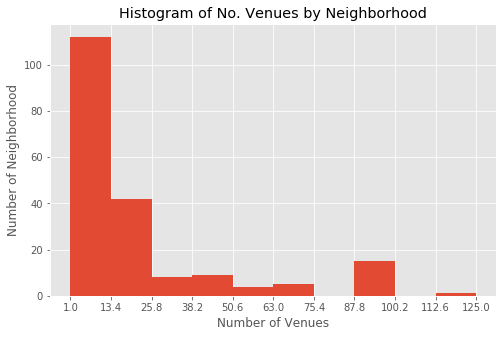

In [15]:
# np.histogram returns 2 values
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(grouped_venues)


grouped_venues.plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of No. Venues by Neighborhood') # add a title to the histogram
plt.ylabel('Number of Neighborhood') # add y-label
plt.xlabel('Number of Venues') # add x-label

plt.show()


**There are 2 interesting findings in the above histogram:**
1. A majority of neighborhoods have less than 50 venues
2. There is one neighborhod which have more than 100 venues retrieved (*St. James Town*). This is due to a duplicated neighborhood name in the `df_neighborhood` dataframe.

To fix these issue and make the analysis more impactful, I will ***only consider neighborhoods that have more than 50 venues retrieved.***

In [16]:
# Filter grouped_venues to get a list of neighborhoods that fit the criteria
grouped_venues = grouped_venues[grouped_venues >= 50]
print('We end up with a list of {} neighborhoods with more than 50 venues:'.format(grouped_venues.shape[0]))
print(grouped_venues.index.tolist())


# Filter toronto_venues by this neighborhood list
toronto_venues = toronto_venues.loc[toronto_venues['Neighborhood'].isin(grouped_venues.index.tolist())]
toronto_venues.groupby('Neighborhood').count()

We end up with a list of 25 neighborhoods with more than 50 venues:
['St. James Town', 'Garden District', 'Victoria Hotel', 'Harbourfront East', 'Ryerson', 'First Canadian Place', 'Toronto Dominion Centre', 'Commerce Court', 'Toronto Islands', 'Design Exchange', 'Underground city', 'Union Station', 'Stn A PO Boxes', 'Richmond', 'King', 'Adelaide', 'Church and Wellesley', 'Fairview', 'Oriole', 'Henry Farm', 'Central Bay Street', 'Grange Park', 'Berczy Park', 'Kensington Market', 'Chinatown']


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,93,93,93,93,93,93
Berczy Park,56,56,56,56,56,56
Central Bay Street,63,63,63,63,63,63
Chinatown,56,56,56,56,56,56
Church and Wellesley,74,74,74,74,74,74
Commerce Court,100,100,100,100,100,100
Design Exchange,100,100,100,100,100,100
Fairview,69,69,69,69,69,69
First Canadian Place,100,100,100,100,100,100


<a name="section4"></a>
# IV. CLUSTER NEIGHBORHOODS IN TORONTO

[Back to Top](#top)

<a name="section4a"></a>
### 4a. Preprocess data for Clustering

##### 1. One-hot encoding

In [17]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="").drop('Neighborhood', axis=1)

# add neighborhood column back to dataframe
toronto_onehot.insert(0, 'Neighborhood', toronto_venues['Neighborhood'])
print('Dimensions: ', toronto_onehot.shape)
toronto_onehot.head()

Dimensions:  (2166, 191)


,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Theme Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
221,Garden District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,Garden District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223,Garden District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224,Garden District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
225,Garden District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**2. Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [18]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print('Dimensions: ', toronto_grouped.shape)
toronto_grouped.head()

Dimensions:  (25, 191)


,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Theme Restaurant,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.000000,0.021505,0.0,0.0,0.010753,0.010753,0.000000,0.010753,0.000000,...,0.000000,0.0,0.0,0.010753,0.0,0.000000,0.000000,0.000000,0.010753,0.000000
1,Berczy Park,0.000000,0.000000,0.0,0.0,0.017857,0.000000,0.000000,0.000000,0.017857,...,0.000000,0.0,0.0,0.017857,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,Central Bay Street,0.000000,0.000000,0.0,0.0,0.000000,0.015873,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.015873,0.0,0.000000,0.000000,0.000000,0.000000,0.015873
3,Chinatown,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.017857,0.000000,0.000000,...,0.000000,0.0,0.0,0.035714,0.0,0.053571,0.017857,0.000000,0.000000,0.000000
4,Church and Wellesley,0.013514,0.013514,0.0,0.0,0.000000,0.000000,0.013514,0.000000,0.000000,...,0.013514,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.013514,0.000000,0.027027


**3. Create dataframe with 10 most common venue of each neighborhood**

In [19]:
# Write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


# Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Restaurant,Clothing Store,Deli / Bodega,Gym,Hotel,Thai Restaurant,Bookstore,Seafood Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Beer Bar,Restaurant,Café,Cheese Shop,Bakery,Eastern European Restaurant,Butcher
2,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Bar,Department Store,Burger Joint,Ice Cream Shop,Salad Place
3,Chinatown,Café,Coffee Shop,Mexican Restaurant,Bakery,Vietnamese Restaurant,Gaming Cafe,Bar,Dessert Shop,Vegetarian / Vegan Restaurant,Doner Restaurant
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gay Bar,Gastropub


<a name="section4b"></a>
### 4b. Cluster Neighborhoods

In [20]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 0, 3, 1, 4, 4, 2, 4, 1])

**Let's create a new dataframe that include the clusters as well as the top 10 venues for each neighborhood**

In [21]:
# Add cluster labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_neighborhood

# Merge dataframes to a new one listing each neighborhood with latitudes, longitudes, and top 10 venue types
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner')
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,1,Clothing Store,Coffee Shop,Restaurant,Bubble Tea Shop,Italian Restaurant,Cosmetics Shop,Japanese Restaurant,Café,Middle Eastern Restaurant,Movie Theater
15,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937,1,Clothing Store,Coffee Shop,Restaurant,Bubble Tea Shop,Italian Restaurant,Cosmetics Shop,Japanese Restaurant,Café,Middle Eastern Restaurant,Movie Theater
27,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,Italian Restaurant,Cocktail Bar,Gastropub,American Restaurant,Pizza Place,Bakery,Park
187,M4X,Downtown Toronto,St. James Town,43.667967,-79.367675,1,Coffee Shop,Café,Restaurant,Italian Restaurant,Cocktail Bar,Gastropub,American Restaurant,Pizza Place,Bakery,Park
37,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cocktail Bar,Seafood Restaurant,Beer Bar,Restaurant,Café,Cheese Shop,Bakery,Eastern European Restaurant,Butcher


**'Tis the moment, let's visualize the clusters**

In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a name="section5"></a>
# V. Examine the Clusters

[Back to Top](#top)

### Cluster 1

In [23]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Central Bay Street,0,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Bar,Department Store,Burger Joint,Ice Cream Shop,Salad Place
61,Harbourfront East,0,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Fried Chicken Joint,Restaurant,Sporting Goods Shop,Scenic Lookout,Brewery
62,Union Station,0,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Fried Chicken Joint,Restaurant,Sporting Goods Shop,Scenic Lookout,Brewery
63,Toronto Islands,0,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Fried Chicken Joint,Restaurant,Sporting Goods Shop,Scenic Lookout,Brewery


### Cluster 2

In [24]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Garden District,1,Clothing Store,Coffee Shop,Restaurant,Bubble Tea Shop,Italian Restaurant,Cosmetics Shop,Japanese Restaurant,Café,Middle Eastern Restaurant,Movie Theater
15,Ryerson,1,Clothing Store,Coffee Shop,Restaurant,Bubble Tea Shop,Italian Restaurant,Cosmetics Shop,Japanese Restaurant,Café,Middle Eastern Restaurant,Movie Theater
27,St. James Town,1,Coffee Shop,Café,Restaurant,Italian Restaurant,Cocktail Bar,Gastropub,American Restaurant,Pizza Place,Bakery,Park
187,St. James Town,1,Coffee Shop,Café,Restaurant,Italian Restaurant,Cocktail Bar,Gastropub,American Restaurant,Pizza Place,Bakery,Park
37,Berczy Park,1,Coffee Shop,Cocktail Bar,Seafood Restaurant,Beer Bar,Restaurant,Café,Cheese Shop,Bakery,Eastern European Restaurant,Butcher
182,Stn A PO Boxes,1,Coffee Shop,Café,Seafood Restaurant,Cocktail Bar,Beer Bar,Restaurant,Japanese Restaurant,Italian Restaurant,Breakfast Spot,Creperie
194,Church and Wellesley,1,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gay Bar,Gastropub


### Cluster 3

In [25]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
55,Fairview,2,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Electronics Store,Bus Station,Cosmetics Shop,Jewelry Store,Food Court,Japanese Restaurant
56,Henry Farm,2,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Electronics Store,Bus Station,Cosmetics Shop,Jewelry Store,Food Court,Japanese Restaurant
57,Oriole,2,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Electronics Store,Bus Station,Cosmetics Shop,Jewelry Store,Food Court,Japanese Restaurant


### Cluster 4

In [26]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
149,Kensington Market,3,Café,Coffee Shop,Mexican Restaurant,Bakery,Vietnamese Restaurant,Gaming Cafe,Bar,Dessert Shop,Vegetarian / Vegan Restaurant,Doner Restaurant
150,Chinatown,3,Café,Coffee Shop,Mexican Restaurant,Bakery,Vietnamese Restaurant,Gaming Cafe,Bar,Dessert Shop,Vegetarian / Vegan Restaurant,Doner Restaurant
151,Grange Park,3,Café,Coffee Shop,Mexican Restaurant,Bakery,Vietnamese Restaurant,Gaming Cafe,Bar,Dessert Shop,Vegetarian / Vegan Restaurant,Doner Restaurant


### Cluster 5

In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Richmond,4,Coffee Shop,Café,Restaurant,Clothing Store,Deli / Bodega,Gym,Hotel,Thai Restaurant,Bookstore,Seafood Restaurant
50,Adelaide,4,Coffee Shop,Café,Restaurant,Clothing Store,Deli / Bodega,Gym,Hotel,Thai Restaurant,Bookstore,Seafood Restaurant
51,King,4,Coffee Shop,Café,Restaurant,Clothing Store,Deli / Bodega,Gym,Hotel,Thai Restaurant,Bookstore,Seafood Restaurant
73,Toronto Dominion Centre,4,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,Salad Place,Asian Restaurant
74,Design Exchange,4,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,Salad Place,Asian Restaurant
86,Commerce Court,4,Coffee Shop,Café,Restaurant,Hotel,American Restaurant,Gym,Deli / Bodega,Japanese Restaurant,Italian Restaurant,Seafood Restaurant
87,Victoria Hotel,4,Coffee Shop,Café,Restaurant,Hotel,American Restaurant,Gym,Deli / Bodega,Japanese Restaurant,Italian Restaurant,Seafood Restaurant
189,First Canadian Place,4,Coffee Shop,Café,Japanese Restaurant,Restaurant,Gym,Hotel,Salad Place,American Restaurant,Deli / Bodega,Seafood Restaurant
190,Underground city,4,Coffee Shop,Café,Japanese Restaurant,Restaurant,Gym,Hotel,Salad Place,American Restaurant,Deli / Bodega,Seafood Restaurant


<a name="conclusion"></a>
### Conclusion

There seems to be a lot of neighborhoods that has similar venues, possibly due to duplicate or too close coordinates. Nevertheless, there are some degree of distinction between these neighborhoods:  
  * **Cluster 1** seems to have ***many scenaries*** and less places for food and drinks.  
  * **Cluster 2** has all top 10 venues being places where one can find something to eat or drink, some degree of ***cuisine diversity***.
  * **Cluster 3** looks like a ***residential area***, and indeed it appear to be in the suburban on the map.
  * **Cluster 4** is very similar to 3, but ***less diverse***.
  * **Cluster 5** seems to be a ***downtown living area*** for both residents and tourists, evident by the overwhelming number of coffee shops and hotel, restaurant, and gym

[Back to Top](#top)